<a href="https://colab.research.google.com/github/bhargav23/EVA4/blob/master/S10/EVA_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')


In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np


train_transforms = AlbumentationTransforms(
    [ A.Rotate((-30.0, 30.0)),
      A.HorizontalFlip(),
      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      A.Cutout(num_holes=6)])




test_transforms = AlbumentationTransforms([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(trainset)
testloader = dataloader.load(testset)

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 frog horse  bird  frog


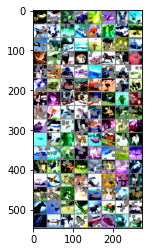

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import evamodel

net = evamodel.ResNet18()

In [0]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [11]:
import sys
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


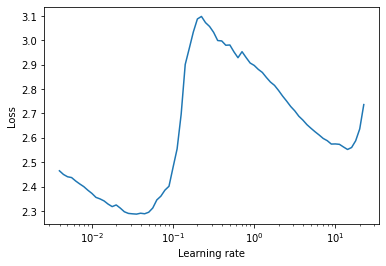

In [12]:
LR = lr_finder.history['lr'][0]

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [13]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test

model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    val = test(model, device, testloader)
    scheduler.step(val)


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.2746418714523315 Batch_id=390 Accuracy=36.53: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4893, Accuracy: 5107/10000 (51.07%)

EPOCH: 1


Loss=1.159593105316162 Batch_id=390 Accuracy=50.84: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3898, Accuracy: 6102/10000 (61.02%)

EPOCH: 2


Loss=1.0221569538116455 Batch_id=390 Accuracy=58.20: 100%|██████████| 391/391 [00:31<00:00, 12.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3352, Accuracy: 6648/10000 (66.48%)

EPOCH: 3


Loss=0.989236056804657 Batch_id=390 Accuracy=63.30: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3289, Accuracy: 6711/10000 (67.11%)

EPOCH: 4


Loss=0.8107268214225769 Batch_id=390 Accuracy=66.28: 100%|██████████| 391/391 [00:31<00:00, 12.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2597, Accuracy: 7403/10000 (74.03%)

EPOCH: 5


Loss=0.7858917713165283 Batch_id=390 Accuracy=69.32: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2772, Accuracy: 7228/10000 (72.28%)

EPOCH: 6


Loss=0.7505620718002319 Batch_id=390 Accuracy=71.23: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2456, Accuracy: 7544/10000 (75.44%)

EPOCH: 7


Loss=0.778989315032959 Batch_id=390 Accuracy=73.20: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2162, Accuracy: 7838/10000 (78.38%)

EPOCH: 8


Loss=0.7886961698532104 Batch_id=390 Accuracy=74.52: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2426, Accuracy: 7574/10000 (75.74%)

EPOCH: 9


Loss=0.5985262393951416 Batch_id=390 Accuracy=76.31: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1957, Accuracy: 8043/10000 (80.43%)

EPOCH: 10


Loss=0.6221840381622314 Batch_id=390 Accuracy=77.06: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1855, Accuracy: 8145/10000 (81.45%)

EPOCH: 11


Loss=0.7565633058547974 Batch_id=390 Accuracy=78.07: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2055, Accuracy: 7945/10000 (79.45%)

EPOCH: 12


Loss=0.6380140781402588 Batch_id=390 Accuracy=78.85: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1789, Accuracy: 8211/10000 (82.11%)

EPOCH: 13


Loss=0.5238833427429199 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1820, Accuracy: 8180/10000 (81.80%)

EPOCH: 14


Loss=0.5942842960357666 Batch_id=390 Accuracy=80.44: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1651, Accuracy: 8349/10000 (83.49%)

EPOCH: 15


Loss=0.4462319314479828 Batch_id=390 Accuracy=81.34: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1621, Accuracy: 8379/10000 (83.79%)

EPOCH: 16


Loss=0.5225018262863159 Batch_id=390 Accuracy=82.12: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1720, Accuracy: 8280/10000 (82.80%)

EPOCH: 17


Loss=0.49360567331314087 Batch_id=390 Accuracy=82.54: 100%|██████████| 391/391 [00:31<00:00, 12.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1683, Accuracy: 8317/10000 (83.17%)

EPOCH: 18


Loss=0.5647981762886047 Batch_id=390 Accuracy=83.50: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1519, Accuracy: 8481/10000 (84.81%)

EPOCH: 19


Loss=0.4546812176704407 Batch_id=390 Accuracy=83.80: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1627, Accuracy: 8373/10000 (83.73%)

EPOCH: 20


Loss=0.34677639603614807 Batch_id=390 Accuracy=84.45: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1609, Accuracy: 8391/10000 (83.91%)

EPOCH: 21


Loss=0.2942161560058594 Batch_id=390 Accuracy=84.72: 100%|██████████| 391/391 [00:31<00:00, 12.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1709, Accuracy: 8291/10000 (82.91%)

EPOCH: 22


Loss=0.43140697479248047 Batch_id=390 Accuracy=85.20: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1351, Accuracy: 8649/10000 (86.49%)

EPOCH: 23


Loss=0.39114895462989807 Batch_id=390 Accuracy=85.69: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1513, Accuracy: 8487/10000 (84.87%)

EPOCH: 24


Loss=0.4944084584712982 Batch_id=390 Accuracy=85.91: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1425, Accuracy: 8575/10000 (85.75%)

EPOCH: 25


Loss=0.2980476915836334 Batch_id=390 Accuracy=86.23: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1385, Accuracy: 8615/10000 (86.15%)

EPOCH: 26


Loss=0.5044263601303101 Batch_id=390 Accuracy=86.80: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1429, Accuracy: 8571/10000 (85.71%)

EPOCH: 27


Loss=0.3579470217227936 Batch_id=390 Accuracy=87.22: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1420, Accuracy: 8580/10000 (85.80%)

EPOCH: 28


Loss=0.3875410556793213 Batch_id=390 Accuracy=87.52: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1514, Accuracy: 8486/10000 (84.86%)

EPOCH: 29


Loss=0.25060731172561646 Batch_id=390 Accuracy=87.67: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1307, Accuracy: 8693/10000 (86.93%)

EPOCH: 30


Loss=0.3852759003639221 Batch_id=390 Accuracy=87.60: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1379, Accuracy: 8621/10000 (86.21%)

EPOCH: 31


Loss=0.32984471321105957 Batch_id=390 Accuracy=88.47: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1256, Accuracy: 8744/10000 (87.44%)

EPOCH: 32


Loss=0.28156325221061707 Batch_id=390 Accuracy=88.60: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1330, Accuracy: 8670/10000 (86.70%)

EPOCH: 33


Loss=0.23820428550243378 Batch_id=390 Accuracy=88.90: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1322, Accuracy: 8678/10000 (86.78%)

EPOCH: 34


Loss=0.3690856099128723 Batch_id=390 Accuracy=89.23: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1280, Accuracy: 8720/10000 (87.20%)

EPOCH: 35


Loss=0.42236000299453735 Batch_id=390 Accuracy=89.43: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1285, Accuracy: 8715/10000 (87.15%)

EPOCH: 36


Loss=0.24387888610363007 Batch_id=390 Accuracy=89.65: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1294, Accuracy: 8706/10000 (87.06%)

EPOCH: 37


Loss=0.19524428248405457 Batch_id=390 Accuracy=89.99: 100%|██████████| 391/391 [00:31<00:00, 12.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1304, Accuracy: 8696/10000 (86.96%)

EPOCH: 38


Loss=0.3975647985935211 Batch_id=390 Accuracy=90.21: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1246, Accuracy: 8754/10000 (87.54%)

EPOCH: 39


Loss=0.23853488266468048 Batch_id=390 Accuracy=90.24: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1242, Accuracy: 8758/10000 (87.58%)

EPOCH: 40


Loss=0.218196839094162 Batch_id=390 Accuracy=90.44: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1168, Accuracy: 8832/10000 (88.32%)

EPOCH: 41


Loss=0.28898727893829346 Batch_id=390 Accuracy=90.79: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1200, Accuracy: 8800/10000 (88.00%)

EPOCH: 42


Loss=0.21601548790931702 Batch_id=390 Accuracy=90.74: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1257, Accuracy: 8743/10000 (87.43%)

EPOCH: 43


Loss=0.3492859899997711 Batch_id=390 Accuracy=91.01: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1242, Accuracy: 8758/10000 (87.58%)

EPOCH: 44


Loss=0.2321244776248932 Batch_id=390 Accuracy=91.16: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1179, Accuracy: 8821/10000 (88.21%)

EPOCH: 45


Loss=0.24820008873939514 Batch_id=390 Accuracy=91.13: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1199, Accuracy: 8801/10000 (88.01%)

EPOCH: 46


Loss=0.15380528569221497 Batch_id=390 Accuracy=91.41: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1198, Accuracy: 8802/10000 (88.02%)

EPOCH: 47


Loss=0.3162462115287781 Batch_id=390 Accuracy=91.67: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1173, Accuracy: 8827/10000 (88.27%)

EPOCH: 48


Loss=0.25172120332717896 Batch_id=390 Accuracy=91.84: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1222, Accuracy: 8778/10000 (87.78%)

EPOCH: 49


Loss=0.32138878107070923 Batch_id=390 Accuracy=91.82: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]



Test set: Average loss: 0.1198, Accuracy: 8802/10000 (88.02%)



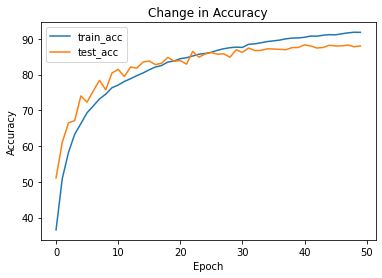

In [14]:
from evascheduler import draw_graph
draw_graph()


In [0]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

25


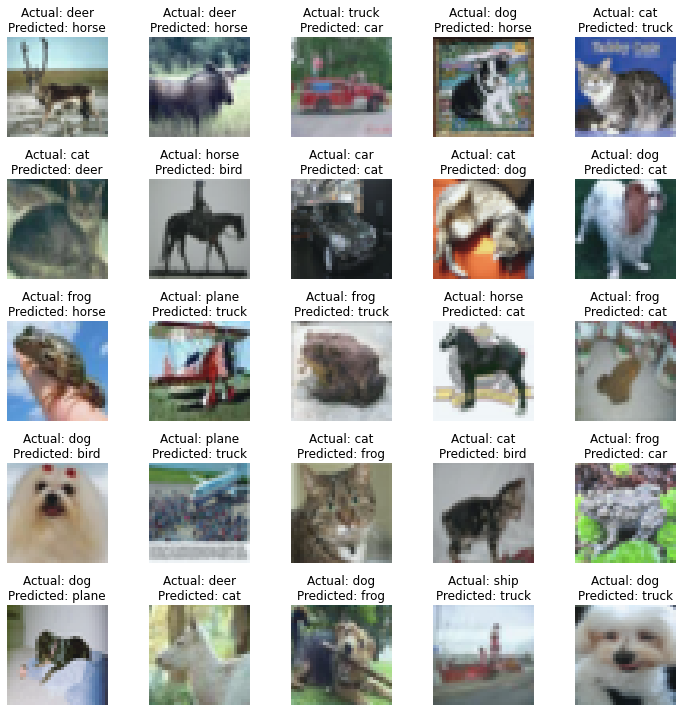

In [16]:
import utils
from utils import plot_images
plot_images(misclassified,classes,"misclassified.png")

In [0]:
model_save_name = 'model.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [18]:
model_save_name = 'model.pt'
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [19]:
'''
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
'''

'\nprint("Model\'s state_dict:")\nfor param_tensor in model.state_dict():\n    print(param_tensor, "\t", model.state_dict()[param_tensor].size())\n'

In [0]:
import grad_cam as gradcamAbs

In [0]:
config = dict(model_type='resnet', arch=model, layer_name='layer4')
means=(0.485, 0.456, 0.406)
stds=(0.229, 0.224, 0.225)
gcam = gradcamAbs.GradCamAbs(device, config, means, stds)

In [22]:
gradcam_images, pred_results = gcam.applyOnImages(dataloader=testloader, num_of_images=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


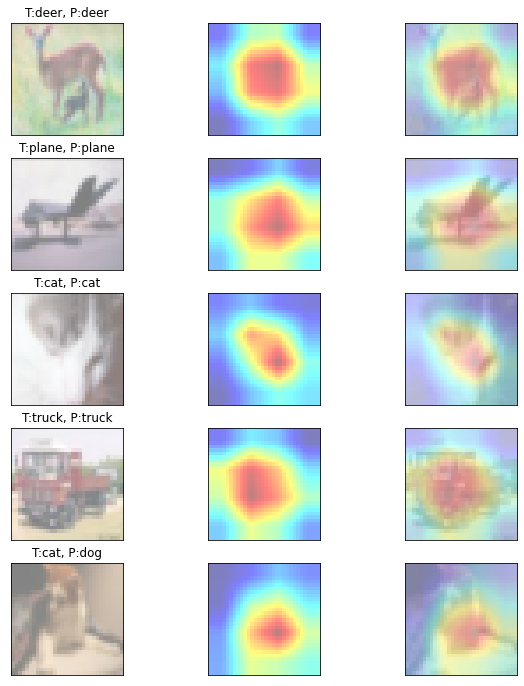

In [23]:
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result")